In [63]:
file = '/home/bernie/projects/array.json'
hmargs = {
    'aprx': 'paca',
    'basis': 'linear',
    'admis': '2',
    'eta': 1.2,
    'eps': 1e-12,
    'm': 4,
    'clf': 16,
    'eps_aca': 0.01,
    'rk': 0,
    'q_reg': 2,
    'q_sing': 4,
    'strict': True,
}
refn = 9
freqs = 0, 50e6, 1e6
c = 1500

In [64]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from cnld import abstract, fem, bem


array = abstract.load(file)
freqs = np.arange(freqs[0], freqs[1] + freqs[2], freqs[2])

F = np.array(fem.array_f_spmatrix(array, refn).todense())
b = np.sum(F, axis=1)

nrmse = np.zeros(len(freqs))
xfm_mean = np.zeros(len(freqs))
xhm_mean = np.zeros(len(freqs))

for i, f in enumerate(tqdm(freqs)):

    k = 2 * np.pi * f / c
    Zfm = bem.array_z_matrix(array, refn, k, format='FullFormat', **hmargs)
    Zhm = bem.array_z_matrix(array, refn, k, format='HFormat', **hmargs)
    
    xfm = np.conj(Zfm.lu().lusolve(b))
    xhm = np.conj(Zhm.lu().lusolve(b))
    
    xfm_mean[i] = np.mean(np.abs(xfm))
    xhm_mean[i] = np.mean(np.abs(xhm))
    nrmse[i] = np.sqrt(np.sum(np.abs(xfm - xhm)**2)) / np.max(np.abs(xfm))


100%|██████████| 51/51 [02:44<00:00,  3.18s/it]


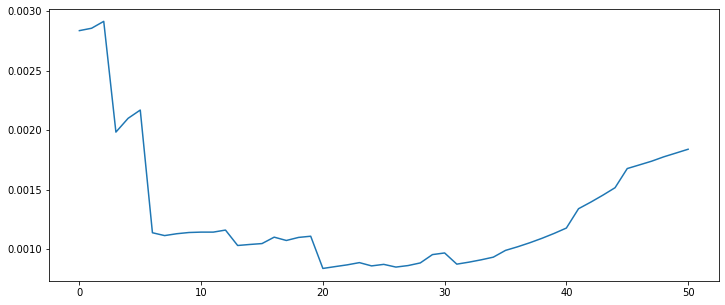

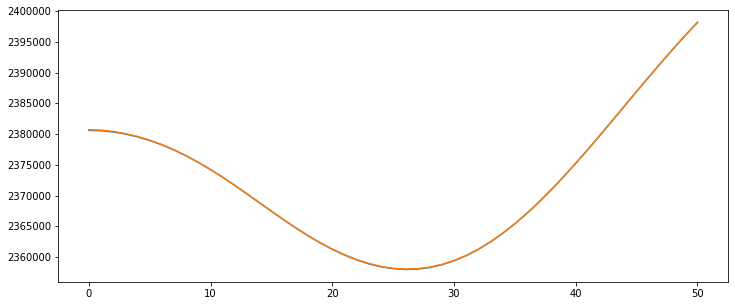

In [66]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(freqs / 1e6, nrmse)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(freqs / 1e6, xfm_mean)
ax.plot(freqs / 1e6, xhm_mean)